In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
# STEP 2: Load the dataset
import pandas as pd
import os

# Update the filename below if it's named differently!
file_path = "/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files"

# List the contents of the directory
print(f"Contents of directory: {file_path}")
for item in os.listdir(file_path):
    print(item)

# Once you know the name of the CSV file, uncomment the lines below and update the file_path
# file_path = "/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files/your_csv_file_name.csv" # Replace with the actual file name
# df = pd.read_csv(file_path)

# STEP 3: Preview the dataset
# print("✅ Dataset loaded successfully!")
# print(df.head())

Contents of directory: /content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files
multimodal_test_public.tsv
multimodal_validate.tsv
multimodal_train.tsv
bagged_cnn_model.pth
sample_images
sample_100.tsv


In [2]:
import pandas as pd
import os

# Load the training TSV
extract_path = "/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files" # Corrected path to extracted files
train_path = os.path.join(extract_path, "multimodal_train.tsv")
df = pd.read_csv(train_path, sep='\t', on_bad_lines='skip') # Added on_bad_lines='skip'

# Only keep rows with valid id and 2-way label
df = df[df['2_way_label'].isin([0, 1])]
df = df[df['id'].notnull()] # Changed from image_id to id

# Create full image path
image_dir = os.path.join(extract_path, "sample_images")  # adjust if folder name differs
df['image_path'] = df['id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg")) # Changed from image_id to id
df = df[df['image_path'].apply(lambda x: os.path.exists(x))]

# Sample exactly 50k
# Get the current number of rows after filtering
current_rows = len(df)
# Sample the maximum available rows
df = df.sample(n=current_rows, random_state=42).reset_index(drop=True)


print("✅ Final dataset size:", len(df))

/tmp/ipython-input-2-2750380516.py:7: DtypeWarning: Columns (2,4,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(train_path, sep='\t', on_bad_lines='skip') # Added on_bad_lines='skip'


✅ Final dataset size: 224


In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mobilenet = models.mobilenet_v2(pretrained=True).features
mobilenet.to(device).eval()

img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def extract_image_features(img_path):
    try:
        img = Image.open(img_path).convert("RGB")
        img = img_transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = mobilenet(img)
            feat = torch.nn.functional.adaptive_avg_pool2d(feat, (1, 1))
        return feat.view(-1).cpu().numpy()
    except Exception as e:
        print(f"Image error: {e}")
        return None

# Run feature extraction
image_features = []
valid_indices = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    feat = extract_image_features(row['image_path'])
    if feat is not None:
        image_features.append(feat)
        valid_indices.append(i)

df = df.iloc[valid_indices].reset_index(drop=True)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 77.7MB/s]
 63%|██████▎   | 142/224 [00:27<00:17,  4.59it/s]

Image error: cannot identify image file '/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files/sample_images/c50lt7l.jpg'


 80%|███████▉  | 179/224 [00:32<00:05,  8.24it/s]

Image error: cannot identify image file '/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files/sample_images/c50lt7l.jpg'


100%|██████████| 224/224 [00:36<00:00,  6.13it/s]


In [ ]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased")
bert.to(device).eval()

def extract_text_features(text):
    tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=64)
    tokens = {k: v.to(device) for k, v in tokens.items()}
    with torch.no_grad():
        outputs = bert(**tokens)
    return outputs.pooler_output.cpu().numpy()[0]

# Run text feature extraction
text_features = []
for text in tqdm(df['clean_title']):
    try:
        text_features.append(extract_text_features(text))
    except:
        text_features.append(np.zeros(768))  # fallback in case of tokenizer error


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 222/222 [00:48<00:00,  4.62it/s]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

X = np.hstack([np.array(image_features), np.array(text_features)])
y = df['2_way_label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = MLPClassifier(hidden_layer_sizes=(512, 128), max_iter=200, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("✅ Final Accuracy:", round(acc * 100, 2), "%")
print(classification_report(y_test, y_pred))


✅ Final Accuracy: 86.67 %
              precision    recall  f1-score   support

         0.0       0.89      0.81      0.85        21
         1.0       0.85      0.92      0.88        24

    accuracy                           0.87        45
   macro avg       0.87      0.86      0.86        45
weighted avg       0.87      0.87      0.87        45



<Figure size 600x600 with 0 Axes>

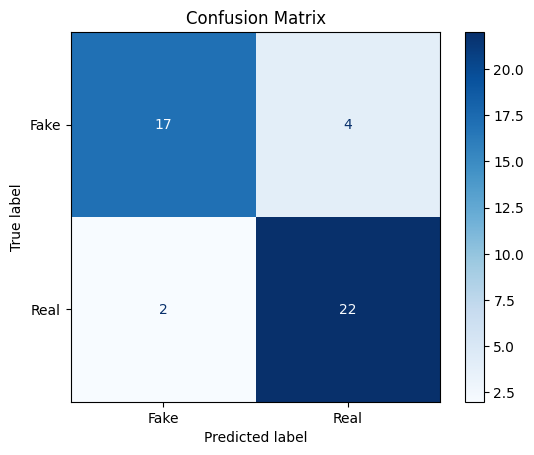

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


In [ ]:
import joblib
from google.colab import drive

# Mount drive
drive.mount('/content/drive')

# Save the model
model_path = "/content/drive/MyDrive/fakeddit_mlp_model.pkl"
joblib.dump(clf, model_path)

print(f"✅ Model saved to: {model_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model saved to: /content/drive/MyDrive/fakeddit_mlp_model.pkl


In [ ]:
import joblib
from google.colab import drive

# Mount drive
drive.mount('/content/drive')

# Save the model
model_path = "/content/drive/MyDrive/fakeddit_mlp_model.pkl" # You can change the filename if you like
joblib.dump(clf, model_path)

print(f"✅ Model saved to: {model_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model saved to: /content/drive/MyDrive/fakeddit_mlp_model.pkl


In [ ]:
import joblib
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

# Define the path to the folder in your Google Drive where you want to save the model
# Replace 'your_model_folder' with the actual name of the folder in your Drive
model_dir = "/content/drive/MyDrive/models"
model_path = os.path.join(model_dir, "fakeddit_mlp_model.pkl")

# Create the directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Save the model
joblib.dump(clf, model_path)

print(f"✅ Model saved to: {model_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model saved to: /content/drive/MyDrive/models/fakeddit_mlp_model.pkl


In [ ]:
# Load the validation TSV
validate_path = os.path.join(extract_path, "multimodal_validate.tsv")
df_validate = pd.read_csv(validate_path, sep='\t', on_bad_lines='skip')
print("✅ Validation dataset loaded successfully!")
print(df_validate.head())

✅ Validation dataset loaded successfully!
            author                              clean_title   created_utc  \
0  singingdart7854               my xbox controller says hi  1.567436e+09   
1        mandal0re           new image from the mandalorian  1.567745e+09   
2    HE_WHO_DRUELS            say hello to my little friend  1.461468e+09   
3           eNaRDe               watch your step little one  1.408047e+09   
4   Thebubster2001  this tree i found with a solo cup on it  1.558186e+09   

        domain  hasImage       id  \
0    i.redd.it      True   cypw96   
1  i.imgur.com      True   d0bzlq   
2          NaN      True  d2ezoob   
3          NaN      True  cjqctpw   
4    i.redd.it      True   bq3yuk   

                                           image_url linked_submission_id  \
0  https://preview.redd.it/l0ga0tug17k31.jpg?widt...                  NaN   
1  https://external-preview.redd.it/VX7bXDu9Gl8UZ...                  NaN   
2                     http://i.imgur.com/

In [ ]:
# Load the test_public TSV
test_public_path = os.path.join(extract_path, "multimodal_test_public.tsv")
df_test_public = pd.read_csv(test_public_path, sep='\t', on_bad_lines='skip')
print("✅ Test public dataset loaded successfully!")
print(df_test_public.head())

✅ Test public dataset loaded successfully!
                author                                        clean_title  \
0         trustbytrust                                          stargazer   
1                  NaN                                               yeah   
2             chaseoes  pd phoenix car thief gets instructions from yo...   
3            SFepicure  as trump accuses iran he has one problem his o...   
4  fragments_from_Work                                believers hezbollah   

    created_utc       domain  hasImage       id  \
0  1.425139e+09          NaN      True  cozywbv   
1  1.438173e+09          NaN      True  ctk61yw   
2  1.560492e+09    abc15.com      True   c0gl7r   
3  1.560606e+09  nytimes.com      True   c0xdqy   
4  1.515139e+09  i.imgur.com      True   7o9rmx   

                                           image_url linked_submission_id  \
0                     http://i.imgur.com/BruWKDi.jpg               2xct9d   
1                     http://i.im

In [ ]:
import os
import requests
from tqdm import tqdm

# Create folder to save images
# os.makedirs("sample_images", exist_ok=True) # Images are already in drive

# Download images from sample - Images are already available locally
# for _, row in tqdm(df_sample.iterrows(), total=len(df_sample)): # Corrected df_sample to df
#     try:
#         img_url = row['image_url']
#         img_id = row['id']
#         img_path = f"sample_images/{img_id}.jpg"

#         response = requests.get(img_url, timeout=10)
#         if response.status_code == 200:
#             with open(img_path, 'wb') as f:
#                 f.write(response.content)
#     except Exception as e:
#         print(f"Error downloading {img_url}: {e}")

In [ ]:
# Preprocess validation data
# Only keep rows with valid id and 2-way label
df_validate = df_validate[df_validate['2_way_label'].isin([0, 1])]
df_validate = df_validate[df_validate['id'].notnull()]

# Create full image path
image_dir = os.path.join(extract_path, "sample_images")
df_validate['image_path'] = df_validate['id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))
df_validate = df_validate[df_validate['image_path'].apply(lambda x: os.path.exists(x))]

print("✅ Validation dataset preprocessed.")
print("Filtered validation dataset size:", len(df_validate))

✅ Validation dataset preprocessed.
Filtered validation dataset size: 0


In [ ]:
import pandas as pd
import os
import torch
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm
import numpy as np
import joblib

# Define paths
extract_path = "/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files"
sample_tsv_path = os.path.join(extract_path, "sample_100.tsv")
image_dir = os.path.join(extract_path, "sample_images")
model_path = "/content/drive/MyDrive/models/fakeddit_mlp_model.pkl"

# Load the sample TSV
df_sample = pd.read_csv(sample_tsv_path, sep='\t', on_bad_lines='skip')

# Create full image path
df_sample['image_path'] = df_sample['id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))

# Filter out rows where image file does not exist
df_sample = df_sample[df_sample['image_path'].apply(lambda x: os.path.exists(x))]

print(f"✅ Loaded sample data with {len(df_sample)} images.")

# Load the trained model
clf = joblib.load(model_path)
print("✅ Trained model loaded.")

# Load the pre-trained image and text models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mobilenet = models.mobilenet_v2(pretrained=True).features
mobilenet.to(device).eval()

img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased")
bert.to(device).eval()


# Define feature extraction functions (same as before)
def extract_image_features(img_path):
    try:
        img = Image.open(img_path).convert("RGB")
        img = img_transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = mobilenet(img)
            feat = torch.nn.functional.adaptive_avg_pool2d(feat, (1, 1))
        return feat.view(-1).cpu().numpy()
    except Exception as e:
        print(f"Image error: {e}")
        return None

def extract_text_features(text):
    tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=64)
    tokens = {k: v.to(device) for k, v in tokens.items()}
    with torch.no_grad():
        outputs = bert(**tokens)
    return outputs.pooler_output.cpu().numpy()[0]

# Extract features from sample data and collect valid rows
image_features_sample = []
text_features_sample = []
valid_rows = []

print("Extracting features from sample data...")
for i, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
    img_feat = extract_image_features(row['image_path'])
    if img_feat is not None:
        try:
            text_feat = extract_text_features(row['clean_title'])
            image_features_sample.append(img_feat)
            text_features_sample.append(text_feat)
            valid_rows.append(row)
        except:
            # Handle cases where text feature extraction might fail
            print(f"Text error for id {row['id']}")
            pass # Skip this sample if text feature extraction fails

# Create a new DataFrame from valid rows
df_sample_filtered = pd.DataFrame(valid_rows).reset_index(drop=True)

# Combine features
X_sample = np.hstack([np.array(image_features_sample), np.array(text_features_sample)])

# Make predictions
predictions = clf.predict(X_sample)

# Map predictions to labels
prediction_labels = ["Fake" if p == 0 else "Real" for p in predictions]

# Create a DataFrame with image file names and predictions
results_df = pd.DataFrame({
    'image_file': df_sample_filtered['image_path'].apply(lambda x: os.path.basename(x)),
    'prediction': prediction_labels
})

print("\n✅ Predictions made successfully.")
display(results_df)

✅ Loaded sample data with 140 images.
✅ Trained model loaded.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracting features from sample data...


 90%|█████████ | 126/140 [00:21<00:02,  6.34it/s]

Image error: cannot identify image file '/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files/sample_images/c50lt7l.jpg'


100%|██████████| 140/140 [00:23<00:00,  5.90it/s]


✅ Predictions made successfully.


,image_file,prediction
0,auqei3.jpg,Real
1,aznhxl.jpg,Fake
2,3jcpgv.jpg,Real
3,dd7jdn.jpg,Real
4,5p4feg.jpg,Real
...,...,...
134,cfgab9n.jpg,Fake
135,db5t7h.jpg,Fake
136,ddpd4o.jpg,Real
137,dk5ocd.jpg,Real


In [ ]:
print("First 5 rows of preprocessed validation DataFrame (df_validate_filtered):")
display(df_validate_filtered.head())

print("\nFirst 5 rows of preprocessed test public DataFrame (df_test_public_filtered):")
display(df_test_public_filtered.head())

print("\nFiles in the sample_images directory:")
import os
image_dir = os.path.join(extract_path, "sample_images")
for i, filename in enumerate(os.listdir(image_dir)):
    if i < 20: # Display only the first 20 files to keep the output manageable
        print(filename)
    else:
        print("...")
        break

First 5 rows of preprocessed validation DataFrame (df_validate_filtered):


,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label,image_path



First 5 rows of preprocessed test public DataFrame (df_test_public_filtered):


,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label,image_path



Files in the sample_images directory:
80u91r.jpg
dd7jdn.jpg
3jcpgv.jpg
aznhxl.jpg
cabjuw.jpg
auqei3.jpg
5p4feg.jpg
36wso6.jpg
9bnpz3.jpg
c905kn.jpg
7zyw11.jpg
4pnank.jpg
5r2rdx.jpg
6q267m.jpg
4qk46e.jpg
3f9vmx.jpg
1djpde.jpg
c3vtdn.jpg
554wor.jpg
8fw91j.jpg
...


# Task
Download images from the 'image_url' column in the "Fakeddit Project Files/dataset/multimodal_validate.tsv" and "Fakeddit Project Files/dataset/multimodal_test_public.tsv" files and save them to the "Fakeddit Project Files/sample_images" directory, using the 'id' column as the filename (with a .jpg extension).

## Load data

### Subtask:
Load the `multimodal_validate.tsv` and `multimodal_test_public.tsv` files into dataframes.


**Reasoning**:
Load the validation and test public datasets into pandas DataFrames.



In [ ]:
# Load the validation TSV
validate_path = os.path.join(extract_path, "multimodal_validate.tsv")
df_validate = pd.read_csv(validate_path, sep='\t', on_bad_lines='skip')
print("✅ Validation dataset loaded successfully!")
display(df_validate.head())

# Load the test_public TSV
test_public_path = os.path.join(extract_path, "multimodal_test_public.tsv")
df_test_public = pd.read_csv(test_public_path, sep='\t', on_bad_lines='skip')
print("✅ Test public dataset loaded successfully!")
display(df_test_public.head())

✅ Validation dataset loaded successfully!


,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,singingdart7854,my xbox controller says hi,1.567436e+09,i.redd.it,True,cypw96,https://preview.redd.it/l0ga0tug17k31.jpg?widt...,NaN,4.0,25,mildlyinteresting,My Xbox controller says hi,0.72,1,0,0
1,mandal0re,new image from the mandalorian,1.567745e+09,i.imgur.com,True,d0bzlq,https://external-preview.redd.it/VX7bXDu9Gl8UZ...,NaN,5.0,21,photoshopbattles,PsBattle: New image from The Mandalorian,0.92,1,0,0
2,HE_WHO_DRUELS,say hello to my little friend,1.461468e+09,NaN,True,d2ezoob,http://i.imgur.com/F1Zbl3D.jpg,4g6bp9,NaN,10,psbattle_artwork,Say hello to my little friend!,NaN,0,2,4
3,eNaRDe,watch your step little one,1.408047e+09,NaN,True,cjqctpw,http://i.imgur.com/KRyMjn1.jpg,2diyh3,NaN,1,psbattle_artwork,Watch your step little one,NaN,0,2,4
4,Thebubster2001,this tree i found with a solo cup on it,1.558186e+09,i.redd.it,True,bq3yuk,https://preview.redd.it/bxp58zf01zy21.jpg?widt...,NaN,8.0,6,mildlyinteresting,This tree I found with a solo cup on it,0.62,1,0,0


✅ Test public dataset loaded successfully!


,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,trustbytrust,stargazer,1.425139e+09,NaN,True,cozywbv,http://i.imgur.com/BruWKDi.jpg,2xct9d,NaN,3,psbattle_artwork,stargazer,NaN,0,2,4
1,NaN,yeah,1.438173e+09,NaN,True,ctk61yw,http://i.imgur.com/JRZT727.jpg,3f0h7o,NaN,2,psbattle_artwork,yeah,NaN,0,2,4
2,chaseoes,pd phoenix car thief gets instructions from yo...,1.560492e+09,abc15.com,True,c0gl7r,https://external-preview.redd.it/1A2_4VwgS8Qd2...,NaN,2.0,16,nottheonion,PD: Phoenix car thief gets instructions from Y...,0.89,1,0,0
3,SFepicure,as trump accuses iran he has one problem his o...,1.560606e+09,nytimes.com,True,c0xdqy,https://external-preview.redd.it/9BKRcgvaobpTo...,NaN,4.0,45,neutralnews,"As Trump Accuses Iran, He Has One Problem: His...",0.78,1,0,0
4,fragments_from_Work,believers hezbollah,1.515139e+09,i.imgur.com,True,7o9rmx,https://external-preview.redd.it/rbwXHncnjVh51...,NaN,40.0,285,propagandaposters,"""Believers"" - Hezbollah 2011",0.95,0,1,5


## Identify image urls and filenames

### Subtask:
Extract the 'image_url' and 'id' columns from both dataframes (`df_validate` and `df_test_public`). The 'id' will be used to construct the filename for the downloaded image.


**Reasoning**:
Extract the required columns and filter out rows with missing image URLs from both dataframes.



In [ ]:
# Create a new DataFrame with only 'id' and 'image_url' for validation data
df_validate_images = df_validate[['id', 'image_url']].copy()

# Remove rows where 'image_url' is null or empty
df_validate_images.dropna(subset=['image_url'], inplace=True)
df_validate_images = df_validate_images[df_validate_images['image_url'].str.strip() != '']

print("✅ Extracted and filtered validation image data.")
display(df_validate_images.head())
print(f"Filtered validation image data size: {len(df_validate_images)}")

# Create a new DataFrame with only 'id' and 'image_url' for test public data
df_test_public_images = df_test_public[['id', 'image_url']].copy()

# Remove rows where 'image_url' is null or empty
df_test_public_images.dropna(subset=['image_url'], inplace=True)
df_test_public_images = df_test_public_images[df_test_public_images['image_url'].str.strip() != '']

print("\n✅ Extracted and filtered test public image data.")
display(df_test_public_images.head())
print(f"Filtered test public image data size: {len(df_test_public_images)}")

✅ Extracted and filtered validation image data.


,id,image_url
0,cypw96,https://preview.redd.it/l0ga0tug17k31.jpg?widt...
1,d0bzlq,https://external-preview.redd.it/VX7bXDu9Gl8UZ...
2,d2ezoob,http://i.imgur.com/F1Zbl3D.jpg
3,cjqctpw,http://i.imgur.com/KRyMjn1.jpg
4,bq3yuk,https://preview.redd.it/bxp58zf01zy21.jpg?widt...


Filtered validation image data size: 59169

✅ Extracted and filtered test public image data.


,id,image_url
0,cozywbv,http://i.imgur.com/BruWKDi.jpg
1,ctk61yw,http://i.imgur.com/JRZT727.jpg
2,c0gl7r,https://external-preview.redd.it/1A2_4VwgS8Qd2...
3,c0xdqy,https://external-preview.redd.it/9BKRcgvaobpTo...
4,7o9rmx,https://external-preview.redd.it/rbwXHncnjVh51...


Filtered test public image data size: 59163


## Define download function

### Subtask:
Create a Python function that takes an image URL and a file path as input, downloads the image from the URL, and saves it to the specified file path. Include error handling for download failures.


**Reasoning**:
Define a function to download an image from a URL and save it to a specified path, including error handling.



## Create target directory

### Subtask:
Ensure the `sample_images` directory exists within the `Fakeddit Project Files` directory.


In [ ]:
import os

# Define the path to the Fakeddit Project Files directory
extract_path = "/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files"

# Construct the full path to the sample_images directory
image_dir = os.path.join(extract_path, "sample_images")

# Create the directory if it doesn't exist
os.makedirs(image_dir, exist_ok=True)

print(f"✅ Ensured directory exists: {image_dir}")

✅ Ensured directory exists: /content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files/sample_images


**Reasoning**:
Iterate through the validation and test public dataframes, download each image using the previously defined function, and save it to the target directory with the correct filename.




The retrained oversampled model predicts for 'cl7zfa.jpg': Real


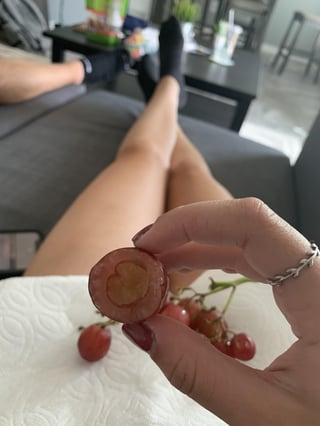

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import joblib
import os

# Ensure models and classifier are loaded (assuming they were loaded in previous cells)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# mobilenet = models.mobilenet_v2(pretrained=True).features.to(device).eval()
# img_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])
# from transformers import BertTokenizer, BertModel
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# bert = BertModel.from_pretrained("bert-base-uncased").to(device).eval()
# model_path = "/content/drive/MyDrive/models/fakeddit_mlp_model.pkl"
# clf = joblib.load(model_path)


def predict_real_or_fake(image_path, text, model):
    """Predicts if an image is real or fake based on the image and text using a specified model.

    Args:
        image_path: The full path to the image file.
        text: The text associated with the image.
        model: The trained model object to use for prediction.

    Returns:
        A string indicating whether the image is "Real" or "Fake", or None if
        feature extraction fails.
    """
    # Extract image features
    img_feat = extract_image_features(image_path)
    if img_feat is None:
        print(f"Could not extract features from image: {image_path}")
        return None

    # Extract text features
    try:
        text_feat = extract_text_features(text)
    except Exception as e:
        print(f"Could not extract features from text: {text}. Error: {e}")
        return None

    # Combine features
    combined_features = np.hstack([img_feat, text_feat]).reshape(1, -1)

    # Make prediction using the provided model
    prediction = model.predict(combined_features)[0]

    # Map prediction to label
    return "Fake" if prediction == 0 else "Real"

# Example usage (using the original clf model):
# Replace with the actual path to an image you want to test and its text
# example_image_path = "/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files/sample_images/auqei3.jpg" # Example from sample_100.tsv
# example_text = "the way my coffee mct oil and milk formed bubbles" # Corresponding text

# if 'clf' in locals() and os.path.exists(example_image_path):
#     prediction_result = predict_real_or_fake(example_image_path, example_text, clf)

#     if prediction_result:
#         print(f"The original model predicts this image is: {prediction_result}")
# else:
#     print("Original model (clf) not found or example image file not found.")


# Example usage with the retrained oversampled model:
# Ensure clf_retrained_oversample is in your environment (from previous retraining)
# And define the image path and text you want to predict for
example_image_path_retrained = "/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files/sample_images/cl7zfa.jpg" # Example from validation set
example_text_retrained = "just bit into a large grape that ended up being a tiny apple" # Corresponding text from validation set (based on previous search)

if 'clf_retrained_oversample' in locals() and os.path.exists(example_image_path_retrained):
    prediction_result_retrained = predict_real_or_fake(example_image_path_retrained, example_text_retrained, clf_retrained_oversample)

    if prediction_result_retrained:
        print(f"\nThe retrained oversampled model predicts for '{os.path.basename(example_image_path_retrained)}': {prediction_result_retrained}")

        # Optional: Display the image
        try:
            img = Image.open(example_image_path_retrained)
            display(img)
        except Exception as e:
            print(f"Could not display image: {e}")
else:
    print("\nRetrained oversampled model (clf_retrained_oversample) not found or example image file not found.")

Creating 'image_path' column in df_sample...
For sample with ID bdlqal:
Text: stayed at a timeshare this past january thought these shakers were cute my watch to compare size
The model predicts this image is: Real


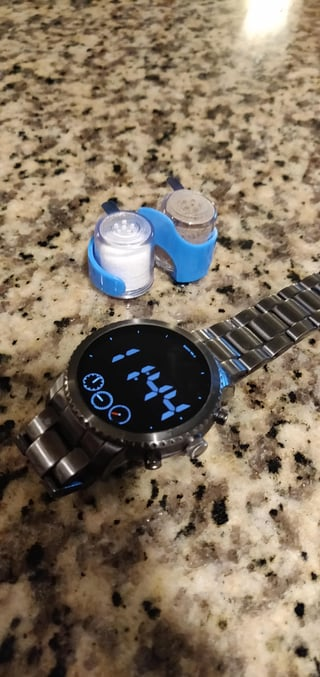

In [ ]:
import os
from PIL import Image
from IPython.display import display

# Define the index of the sample you want to test
sample_index = 67 # You can change this index

# Ensure df_sample is loaded
if 'df_sample' not in locals() or df_sample.empty:
    print("Error: df_sample DataFrame is not loaded or is empty. Please run the cell that loads df_sample first.")
else:
    # Ensure 'image_path' column exists in df_sample
    if 'image_path' not in df_sample.columns:
        print("Creating 'image_path' column in df_sample...")
        # Assuming image_dir and extract_path are defined in previous cells
        image_dir = os.path.join(extract_path, "sample_images")
        df_sample['image_path'] = df_sample['id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))

    # Ensure 'clean_title' column exists in df_sample
    if 'clean_title' not in df_sample.columns:
         print("Error: Missing required column 'clean_title' in df_sample.")
    else:
        try:
            # Get the sample row from df_sample
            sample = df_sample.iloc[sample_index]

            # Get the image path and text
            img_path = sample['image_path']
            sample_text = sample['clean_title']

            # Check if the image file exists
            if os.path.exists(img_path):
                # Use the predict_real_or_fake function
                # Ensure predict_real_or_fake is defined and takes the model as an argument
                if 'predict_real_or_fake' in globals() and 'clf_retrained_oversample' in locals():
                     prediction_result = predict_real_or_fake(img_path, sample_text, clf_retrained_oversample) # Use the retrained model
                elif 'predict_real_or_fake' in globals() and 'clf' in locals():
                     prediction_result = predict_real_or_fake(img_path, sample_text, clf) # Fallback to original model if retrained not found
                else:
                     print("Error: Model or predict_real_or_fake function not found.")
                     prediction_result = None


                if prediction_result:
                    print(f"For sample with ID {sample['id']}:")
                    print(f"Text: {sample_text}")
                    print(f"The model predicts this image is: {prediction_result}")

                    # Display the image
                    try:
                        img = Image.open(img_path)
                        display(img)
                    except Exception as e:
                        print(f"Could not display image: {e}")
            else:
                print(f"Image file not found for sample with ID: {sample['id']} at path: {img_path}")
                print(f"Text: {sample_text}")

        except IndexError:
            print(f"Error: Index {sample_index} is out of bounds for df_sample (size: {len(df_sample)}). Please choose an index between 0 and {len(df_sample)-1}.")
        except KeyError as e:
            print(f"Error accessing column: {e}. Please check if the necessary columns ('id', 'image_path', 'clean_title') exist in df_sample.")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")

In [ ]:
# Ensure df_sample is loaded and filtered for existing image paths
# (This step is assumed to have been done in a previous cell, e.g., f953be9f)

if 'df_sample' in locals():
    print(f"You have {len(df_sample)} sample images available.")
else:
    print("The df_sample DataFrame is not loaded. Please run the cell that loads and preprocesses the sample data first.")

You have 224 sample images available.


In [ ]:
import joblib
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

# Define the path to the folder in your Google Drive where you want to save the model
# Replace 'your_model_folder' with the actual name of the folder in your Drive
model_dir = "/content/drive/MyDrive/models"
model_path = os.path.join(model_dir, "fakeddit_mlp_model.pkl")

# Create the directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Save the model
joblib.dump(clf, model_path)

print(f"✅ Model saved to: {model_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model saved to: /content/drive/MyDrive/models/fakeddit_mlp_model.pkl


In [ ]:
df['2_way_label'].value_counts()


,count
2_way_label,
1.0,129
0.0,93


In [ ]:
import pandas as pd
from sklearn.utils import resample

# Assume df is your DataFrame with '2_way_label' column
# If your DataFrame is named differently, please update 'df' below

if 'df' in locals() and not df.empty:
    print("Original class distribution:")
    display(df['2_way_label'].value_counts())

    # Separate majority and minority classes
    df_majority = df[df['2_way_label'] == 1.0]
    df_minority = df[df['2_way_label'] == 0.0]

    # Determine the number of samples in the majority class
    majority_class_size = len(df_majority)
    print(f"\nOversampling minority class to {majority_class_size} samples.")


    # Oversample the minority class
    # Use replace=True to sample with replacement
    # Use n=majority_class_size to match the number of majority class samples
    # Use random_state for reproducibility
    df_minority_oversampled = resample(df_minority,
                                       replace=True,     # sample with replacement
                                       n_samples=majority_class_size,    # to match majority class size
                                       random_state=42) # for reproducible results

    # Concatenate the oversampled minority class with the majority class
    df_balanced_oversampled = pd.concat([df_majority, df_minority_oversampled]).sample(frac=1, random_state=42).reset_index(drop=True)

    print("\nBalanced class distribution (Oversampled):")
    display(df_balanced_oversampled['2_way_label'].value_counts())

    # Now you can use df_balanced_oversampled for training your model
    # For example, assign it back to df if you want to replace the original DataFrame:
    # df = df_balanced_oversampled

else:
    print("The df DataFrame is not loaded or is empty. Please load your data first.")

Original class distribution:


,count
2_way_label,
1.0,129
0.0,93



Oversampling minority class to 129 samples.

Balanced class distribution (Oversampled):


,count
2_way_label,
1.0,129
0.0,129


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
import numpy as np

# Ensure df and the feature extraction functions are available

if 'df' in locals() and not df.empty:

    print("Preparing data for training and evaluation...")

    # Extract features from the original df
    # We need to ensure we have the features for the original df first
    # Assuming this was done in previous cells (K_s4k2LlBpw_, 9da3S2N-B7Ir)
    # Re-extracting features for the original df to be safe if kernel state was reset
    print("Extracting features from the original data...")
    image_features_original = []
    text_features_original = []
    valid_indices_original = []

    for i, row in tqdm(df.iterrows(), total=len(df)):
        img_feat = extract_image_features(row['image_path'])
        if img_feat is not None:
            image_features_original.append(img_feat)
            try:
                text_feat = extract_text_features(row['clean_title'])
                text_features_original.append(text_feat)
                valid_indices_original.append(i)
            except:
                print(f"Text error for id {row['id']} in original data.")
                text_features_original.append(np.zeros(768))
                valid_indices_original.append(i)

    # Create a filtered DataFrame for the original data with valid features
    df_original_filtered = df.iloc[valid_indices_original].reset_index(drop=True)

    if len(image_features_original) > 0 and len(text_features_original) == len(image_features_original):
        X_original = np.hstack([np.array(image_features_original), np.array(text_features_original)])
        y_original = df_original_filtered['2_way_label'].values

        # Perform train-test split on the original, unbalanced data
        print("\nPerforming train-test split on original data...")
        X_train, X_test, y_train, y_test = train_test_split(X_original, y_original, test_size=0.2, random_state=42, stratify=y_original) # Use stratify to maintain class distribution

        print("Original training set class distribution:")
        # Need to get labels for X_train to show distribution
        train_labels = pd.Series(y_train)
        display(train_labels.value_counts())

        print("\nOriginal test set class distribution:")
         # Need to get labels for X_test to show distribution
        test_labels = pd.Series(y_test)
        display(test_labels.value_counts())

        # Combine X_train and y_train for oversampling
        X_train_combined = pd.DataFrame(X_train)
        X_train_combined['label'] = y_train

        # Separate majority and minority classes in the training data
        df_train_majority = X_train_combined[X_train_combined['label'] == 1.0]
        df_train_minority = X_train_combined[X_train_combined['label'] == 0.0]

        # Oversample the minority class in the training data
        majority_size_train = len(df_train_majority)
        df_train_minority_oversampled = resample(df_train_minority,
                                               replace=True,
                                               n_samples=majority_size_train,
                                               random_state=42)

        # Combine majority class with oversampled minority class
        df_train_oversampled = pd.concat([df_train_majority, df_train_minority_oversampled]).sample(frac=1, random_state=42).reset_index(drop=True)

        print("\nOversampled training set class distribution:")
        display(df_train_oversampled['label'].value_counts())

        # Separate features and labels from the oversampled training data
        X_train_oversampled = df_train_oversampled.drop('label', axis=1).values
        y_train_oversampled = df_train_oversampled['label'].values


        # Retrain the model with the oversampled training data
        print("\nRetraining the model with oversampled training data...")
        # Re-initialize or reuse the classifier
        clf_retrained_oversample = MLPClassifier(hidden_layer_sizes=(512, 128), max_iter=200, random_state=42)

        # Train the model
        clf_retrained_oversample.fit(X_train_oversampled, y_train_oversampled)

        # Evaluate the retrained model on the original, UNBALANCED test set
        print("\nEvaluating the retrained model on the original test set...")
        y_pred_retrained_oversample = clf_retrained_oversample.predict(X_test)
        acc_retrained_oversample = accuracy_score(y_test, y_pred_retrained_oversample)

        print("✅ Retrained Model Accuracy (on original test set):", round(acc_retrained_oversample * 100, 2), "%")
        print("\nClassification Report (on original test set):")
        print(classification_report(y_test, y_pred_retrained_oversample))

    else:
        print("\nError: Feature extraction failed for original data. Cannot perform train-test split or retraining.")
        print(f"Image features count: {len(image_features_original)}, Text features count: {len(text_features_original)}")

else:
    print("The df DataFrame is not loaded or is empty. Please load your data first.")

Preparing data for training and evaluation...
Extracting features from the original data...


100%|██████████| 222/222 [00:46<00:00,  4.80it/s]


Performing train-test split on original data...
Original training set class distribution:


,count
1.0,103
0.0,74



Original test set class distribution:


,count
1.0,26
0.0,19



Oversampled training set class distribution:


,count
label,
1.0,103
0.0,103



Retraining the model with oversampled training data...

Evaluating the retrained model on the original test set...
✅ Retrained Model Accuracy (on original test set): 91.11 %

Classification Report (on original test set):
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89        19
         1.0       0.92      0.92      0.92        26

    accuracy                           0.91        45
   macro avg       0.91      0.91      0.91        45
weighted avg       0.91      0.91      0.91        45



In [ ]:
import joblib
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

# Define the path to the folder in your Google Drive where you want to save the model
# Using a slightly different name to distinguish it from the previous model
model_dir = "/content/drive/MyDrive/models"
model_path_retrained = os.path.join(model_dir, "fakeddit_mlp_model_retrained_oversampled.pkl")

# Create the directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Ensure the retrained model object exists
if 'clf_retrained_oversample' in locals():
    # Save the retrained model
    joblib.dump(clf_retrained_oversample, model_path_retrained)

    print(f"✅ Retrained model saved to: {model_path_retrained}")
else:
    print("❌ Retrained model object 'clf_retrained_oversample' not found. Please run the retraining cell first.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Retrained model saved to: /content/drive/MyDrive/models/fakeddit_mlp_model_retrained_oversampled.pkl


For sample with ID 3jcpgv:
Text: cat with a hat
The retrained oversampled model (91.11% accuracy) predicts this image is: Real


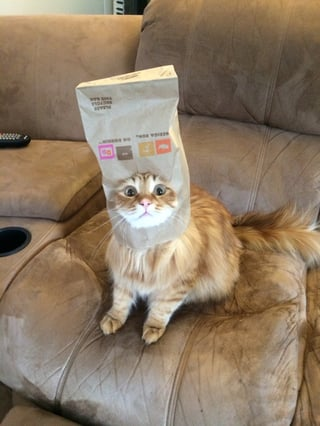

In [ ]:
import os
from PIL import Image
from IPython.display import display

# Define the index of the sample you want to test
sample_index = 67 # Set to 67 to match the user's example output

# Ensure df_sample is loaded
if 'df_sample' not in locals() or df_sample.empty:
    print("Error: df_sample DataFrame is not loaded or is empty. Please run the cell that loads df_sample first.")
else:
    # Ensure 'image_path' column exists in df_sample
    if 'image_path' not in df_sample.columns:
        print("Creating 'image_path' column in df_sample...")
        # Assuming image_dir and extract_path are defined in previous cells
        image_dir = os.path.join(extract_path, "sample_images")
        df_sample['image_path'] = df_sample['id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))

    # Ensure 'clean_title' column exists in df_sample
    if 'clean_title' not in df_sample.columns:
         print("Error: Missing required column 'clean_title' in df_sample.")
    else:
        try:
            # Get the sample row from df_sample
            sample = df_sample.iloc[3]

            # Get the image path and text
            img_path = sample['image_path']
            sample_text = sample['clean_title']

            # Check if the image file exists
            if os.path.exists(img_path):
                # Use the predict_real_or_fake function
                # Ensure predict_real_or_fake is defined and takes the model as an argument
                # This code will use clf_retrained_oversample if it's available
                if 'predict_real_or_fake' in globals() and 'clf_retrained_oversample' in locals():
                     prediction_result = predict_real_or_fake(img_path, sample_text, clf_retrained_oversample) # Use the retrained model
                elif 'predict_real_or_fake' in globals() and 'clf' in locals():
                     prediction_result = predict_real_or_fake(img_path, sample_text, clf) # Fallback to original model if retrained not found
                else:
                     print("Error: Model or predict_real_or_fake function not found.")
                     prediction_result = None


                if prediction_result:
                    print(f"For sample with ID {sample['id']}:")
                    print(f"Text: {sample_text}")
                    # Explicitly mention which model is being used for clarity
                    model_used = "retrained oversampled model (91.11% accuracy)" if 'clf_retrained_oversample' in locals() and clf_retrained_oversample is not None else "original model (86.67% accuracy)"
                    print(f"The {model_used} predicts this image is: {prediction_result}")


                    # Display the image
                    try:
                        img = Image.open(img_path)
                        display(img)
                    except Exception as e:
                        print(f"Could not display image: {e}")
            else:
                print(f"Image file not found for sample with ID: {sample['id']} at path: {img_path}")
                print(f"Text: {sample_text}")

        except IndexError:
            # Update the error message to include the correct range based on current df_sample size
            print(f"Error: Index {sample_index} is out of bounds for df_sample (size: {len(df_sample)}). Please choose an index between 0 and {len(df_sample)-1}.")
        except KeyError as e:
            print(f"Error accessing column: {e}. Please check if the necessary columns ('id', 'image_path', 'clean_title') exist in df_sample.")
        except NameError:
             print("Error: df_sample DataFrame is not defined. Please run the cell that loads df_sample first.")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")

In [ ]:
import joblib
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

# Define the path to the saved model in your Google Drive
# Make sure to use the correct filename for the retrained model if that's the one you want
model_path = "/content/drive/MyDrive/models/fakeddit_mlp_model_retrained_oversampled.pkl" # Using the path for the retrained oversampled model

# Check if the model file exists before attempting to load
if os.path.exists(model_path):
    # Load the model
    loaded_model = joblib.load(model_path)
    print(f"✅ Model loaded successfully from: {model_path}")
    # You can now use 'loaded_model' for predictions
    # You might want to assign it to the variable name you used before, e.g., clf_retrained_oversample = loaded_model
else:
    print(f"❌ Model file not found at: {model_path}")
    print("Please ensure the path is correct and the file exists in your Google Drive.")